In [72]:
import pickle
import os
import numpy as np
import mdtraj
import deeptime

import numpy as np
import matplotlib.pyplot as plt
import mdtraj
import os
import glob
import scipy

import tqdm

import sys
sys.path.append("/home/md-ml/awaghili/cgschnet/cgschnet/scripts")

In [73]:
def load_trajectories(coordinate_files, size_limit=None, join_traj=True):
    coordinate_list = []
    label_list = []

    for cf in coordinate_files:
        batch_label = os.path.basename(cf)
        batch_traj = []
        for subtraj in glob.glob(cf):
            if subtraj.endswith("npy"):
                coords = np.load(subtraj, allow_pickle=True)
                if type(coords) == dict: # One of Raz's benchmark archives
                    batch_label = os.path.join(*(cf.split(os.path.sep)[-2:]))
                    batch_traj.extend(coords["mdtraj_list"])
                else: # A preprocess.py output file
                    batch_label = os.path.join(*(cf.split(os.path.sep)[-3:]))
                    # Convert to NM to match mdtraj coordinates
                    coords = coords/10
                    psf_path = glob.glob(os.path.join(os.path.dirname(cf),"../processed/*_processed.psf"))[0]
                    traj = mdtraj.Trajectory(coords, topology=mdtraj.formats.psf.load_psf(psf_path))
                    batch_traj.append(traj)
            else: # Something mdtraj can open
                traj = mdtraj.load(subtraj)
                batch_traj.append(traj)
        if len(batch_traj) == 0:
            raise RuntimeError(f"{cf} did not match any files")
        
        if join_traj:
            batch_traj = mdtraj.join(batch_traj)

            # Select with a stride that brings the total number of frames down to the size_limit
            if size_limit and len(batch_traj) > size_limit:
                batch_traj = batch_traj[::(len(batch_traj)//size_limit)]

        label_list.append(batch_label)
        coordinate_list.append(batch_traj)

    assert len(coordinate_list) == len(label_list)
    return coordinate_list, label_list


In [74]:
def calculate_component_values(model, coordinates, components):
    component_values = {k: [] for k in components}

    pairs = np.vstack(np.triu_indices(coordinates.n_atoms, k=1)).T
    distances = mdtraj.compute_distances(coordinates, pairs)
    tica_comps = model.tica_model.transform(distances)
    for k, v in component_values.items():
        v.extend(tica_comps[:, k])

    return component_values

In [163]:
model_filename = "/media/DATA_18_TB_1/andy/benchmark_cache/chignolin_300K.tica"
with open(model_filename, 'rb') as f:
    model = pickle.load(f)
    # assert isinstance(model, TicaModel)
    assert hasattr(model, "tica_model")

In [164]:
coordinate_files = [
    # "/mnt/secondary/argon/cg_all_benchmark_finetuneE01_s4/bba*/raw/coordinates.npy",
    # "/home/argon/Stuff/harmonic_net_2025.04.06/reference_models/benchmarkE39_high_density_benchmark_CA_only_2025.04.03_mix1.1_s100_CA_Majewski2022_v1_cutoff2_seq6__wd0_plateaulr5en4_0.1_0_1en3_1en7_bs4_chunk120/bba_model_replicas.npy",
    "/media/DATA_14_TB/daniel_s/cg_all_benchmark_finetuneE01_s4/chignolin*/raw/coordinates.npy",
]

coordinate_list, label_list = load_trajectories(coordinate_files, join_traj=False)
print(coordinate_list)

[[<mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bac1db90>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53ba768310>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bbaf7dd0>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bac20650>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53c5951a90>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bacc9bd0>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53b85abb50>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53b85a95d0>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bae6ca10>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bae6dd50>, <mdtraj.Trajectory

In [155]:
from itertools import chain
import random

# Flatten coordinate_list: list of lists → flat list
all_trajs = list(chain.from_iterable(coordinate_list))

subset_percentage = 10
num_to_sample = max(1, int(len(all_trajs) * (subset_percentage / 100)))

sampled_trajs = [all_trajs[i] for i in range(num_to_sample)]

print(f"Sampled {num_to_sample} trajectories out of {len(all_trajs)} total.")

coordinate_list = [sampled_trajs]
print(coordinate_list)


Sampled 37 trajectories out of 373 total.
[[<mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bb041d10>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bc951850>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53b85dad50>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53c568ff10>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bb365850>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bb0edd90>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53b8600590>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bae5e450>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitcells at 0x7f53bac0ab90>, <mdtraj.Trajectory with 2500 frames, 10 atoms, 10 residues, without unitce

In [165]:
component_to_calculate = 0
component_values = [calculate_component_values(model, c, [component_to_calculate]) for c in coordinate_list[0]]
component_values = [i[component_to_calculate] for i in component_values]

In [166]:
num_bins = 80
component_min = min([min(i) for i in component_values])
component_max = max([max(i) for i in component_values])
component_bins = np.linspace(component_min, component_max, num_bins+1)
# Calculate the binds ourselves because I can't figure out np.digitize tonight - Daniel
# The np.clip call is needed because math here treats the bins as open ranges on the right [a,b), so the max value gets put in next bin
binned_componenents = [np.clip((num_bins*(i-component_min)/(component_max-component_min)).astype(int), None, num_bins-1) for i in component_values]

for i,j in zip(binned_componenents, component_values):
     bad = i[i >= num_bins]
     if len(bad):
          print(bad)
          print(j > component_max)

In [167]:
transition_matrix = np.zeros((num_bins, num_bins), dtype=int)
for i in binned_componenents:
    for j in range(len(i) - 1):
#         if i[j] == i[j+1]:
#             continue
        try:
            transition_matrix[i[j]][i[j+1]] += 1
        except:
            print(j, j+1)
            raise

In [168]:
transition_matrix

array([[  1,  12,  10, ...,   0,   0,   0],
       [ 12,  54,  74, ...,   0,   0,   0],
       [ 17,  75, 203, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  90,  10,   3],
       [  0,   0,   0, ...,  11,   2,   0],
       [  0,   0,   0, ...,   1,   0,   0]])

In [169]:
transition_prob_matrix = transition_matrix.astype(np.double)/np.sum(transition_matrix, axis=1, keepdims=True)
transition_prob_matrix = np.nan_to_num(transition_prob_matrix, nan=0.0)

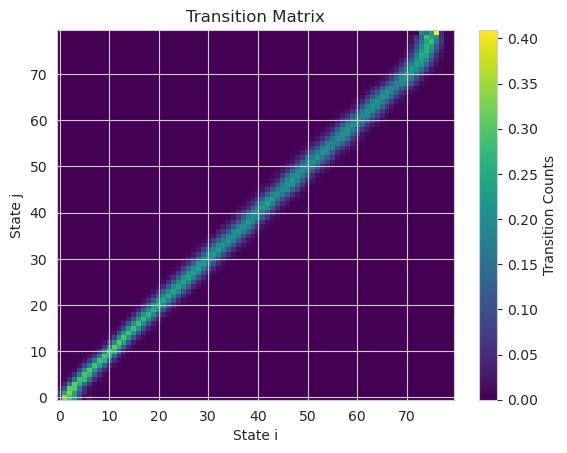

In [170]:
# Plot by ChatGPT
plt.imshow(transition_prob_matrix, origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Transition Counts')
plt.xlabel('State i')
plt.ylabel('State j')
plt.title('Transition Matrix')
plt.show()

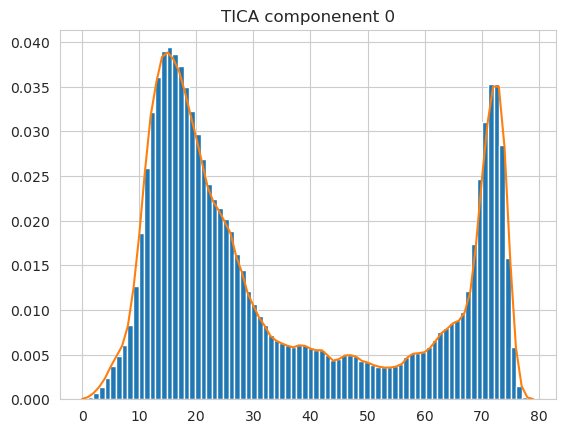

In [171]:
# Linear algebra by ChatGPT
# Solve for the stationary distribution
eigenvalues, eigenvectors = np.linalg.eig(transition_prob_matrix.T)
stationary_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]

assert stationary_vector.shape[1] == 1, "Stationary distribution is not unique"

# Normalize the stationary vector to sum to 1
stationary_distribution = stationary_vector / np.sum(stationary_vector)
stationary_distribution = stationary_distribution.real.flatten()

plt.title(f"TICA componenent {component_to_calculate}")
plt.hist(np.concatenate(binned_componenents), bins=num_bins, density=True)
plt.plot(stationary_distribution)
pass